In [1]:
from epydemix.model import load_predefined_model
from epydemix.visualization import plot_quantiles
import numpy as np
import time

# Speeding Up Simulations with Multiprocessing

In this tutorial, we’ll see how to speed up simulations using **multiprocessing**. Multiprocessing allows you to run computations on multiple CPU cores simultaneously, significantly reducing execution time for computationally intensive tasks.

In Python, parallelization can be achieved in several ways. In this tutorial, we’ll use the [**`multiprocess`**](https://pypi.org/project/multiprocess/) package — a fork of the standard library **`multiprocessing`** module. We prefer `multiprocess` because it integrates better with Jupyter notebooks.

Before we begin, make sure the **`multiprocess`** package is installed:

In [2]:
pip install multiprocess

Note: you may need to restart the kernel to use updated packages.


In [3]:
import multiprocess as mp

## Parallelizing a Simple SIR Model

In this first example, we’ll parallelize the `run_simulations` method of the `EpiModel` class to demonstrate how to integrate **epydemix** with **multiprocess**, and to observe the resulting computational speedup.

We’ll start by creating a standard **SIR** model and measuring the time required to run 50 simulations, each spanning one year:

In [4]:
# create model
model = load_predefined_model("SIR")
Nsim = 50

# run and time the simulations
start = time.time()
results = model.run_simulations(Nsim=Nsim)
end = time.time()

print(f"Time taken: {end - start:.2f} seconds")

Time taken: 3.88 seconds


Let’s now see how to **parallelize** this code. The goal is to distribute multiple simulation runs across different CPU cores so they can be executed simultaneously. This can be achieved in just a few steps:

1. **Wrap the simulation call:**
   Define a small wrapper function around `run_simulations` that takes as input the number of simulations to run. This makes it easier to assign independent chunks of work to each process.

2. **Create a multiprocessing pool:**
   Use a `multiprocess.Pool` object to launch several parallel processes. Each process will execute the wrapper function and run a subset of the total number of simulations.

3. **Combine the results:**
   Once all parallel tasks are complete, collect and merge their outputs (e.g., by stacking lists) into a single result for further analysis.

This approach allows you to take full advantage of multicore CPUs, reducing total computation time, which is especially useful when running large number of simulations or computationally expensive models.

In [5]:
def run_simulations(Nsim):
    """ Wrapper function to run simulations. """
    results = model.run_simulations(Nsim=Nsim)
    return results

# define the number of parallel processes
nprocs = 5

# run and time the simulations in parallel
start = time.time()
with mp.Pool() as pool:
    result = pool.map(run_simulations, [Nsim//nprocs for _ in range(nprocs)])
end = time.time()

print(f"Time taken: {end - start:.2f} seconds")

Time taken: 1.22 seconds


This parallel implementation took roughly 25% of the time required for the classic serial execution, an impressive 4× speed improvement.

However, the output is now a list containing the results from each process, i.e., a list of ```SimulationResults``` objects. To fully leverage epydemix’s features for exploring and visualizing simulation outcomes, we need to combine these results into a single ```SimulationResults``` object.

This can be done easily by concatenating the trajectories from each process, since the model parameters are identical across all runs. The following code snippet shows how to perform this merge step:

In [6]:
from epydemix.model.simulation_results import SimulationResults

merged_results = SimulationResults(
    trajectories=list(np.concatenate([res.trajectories for res in result])), 
    parameters=result[0].parameters)

Finally, we can visualize the combined results just as we normally would, using the standard plotting utilities provided by epydemix:

<Axes: >

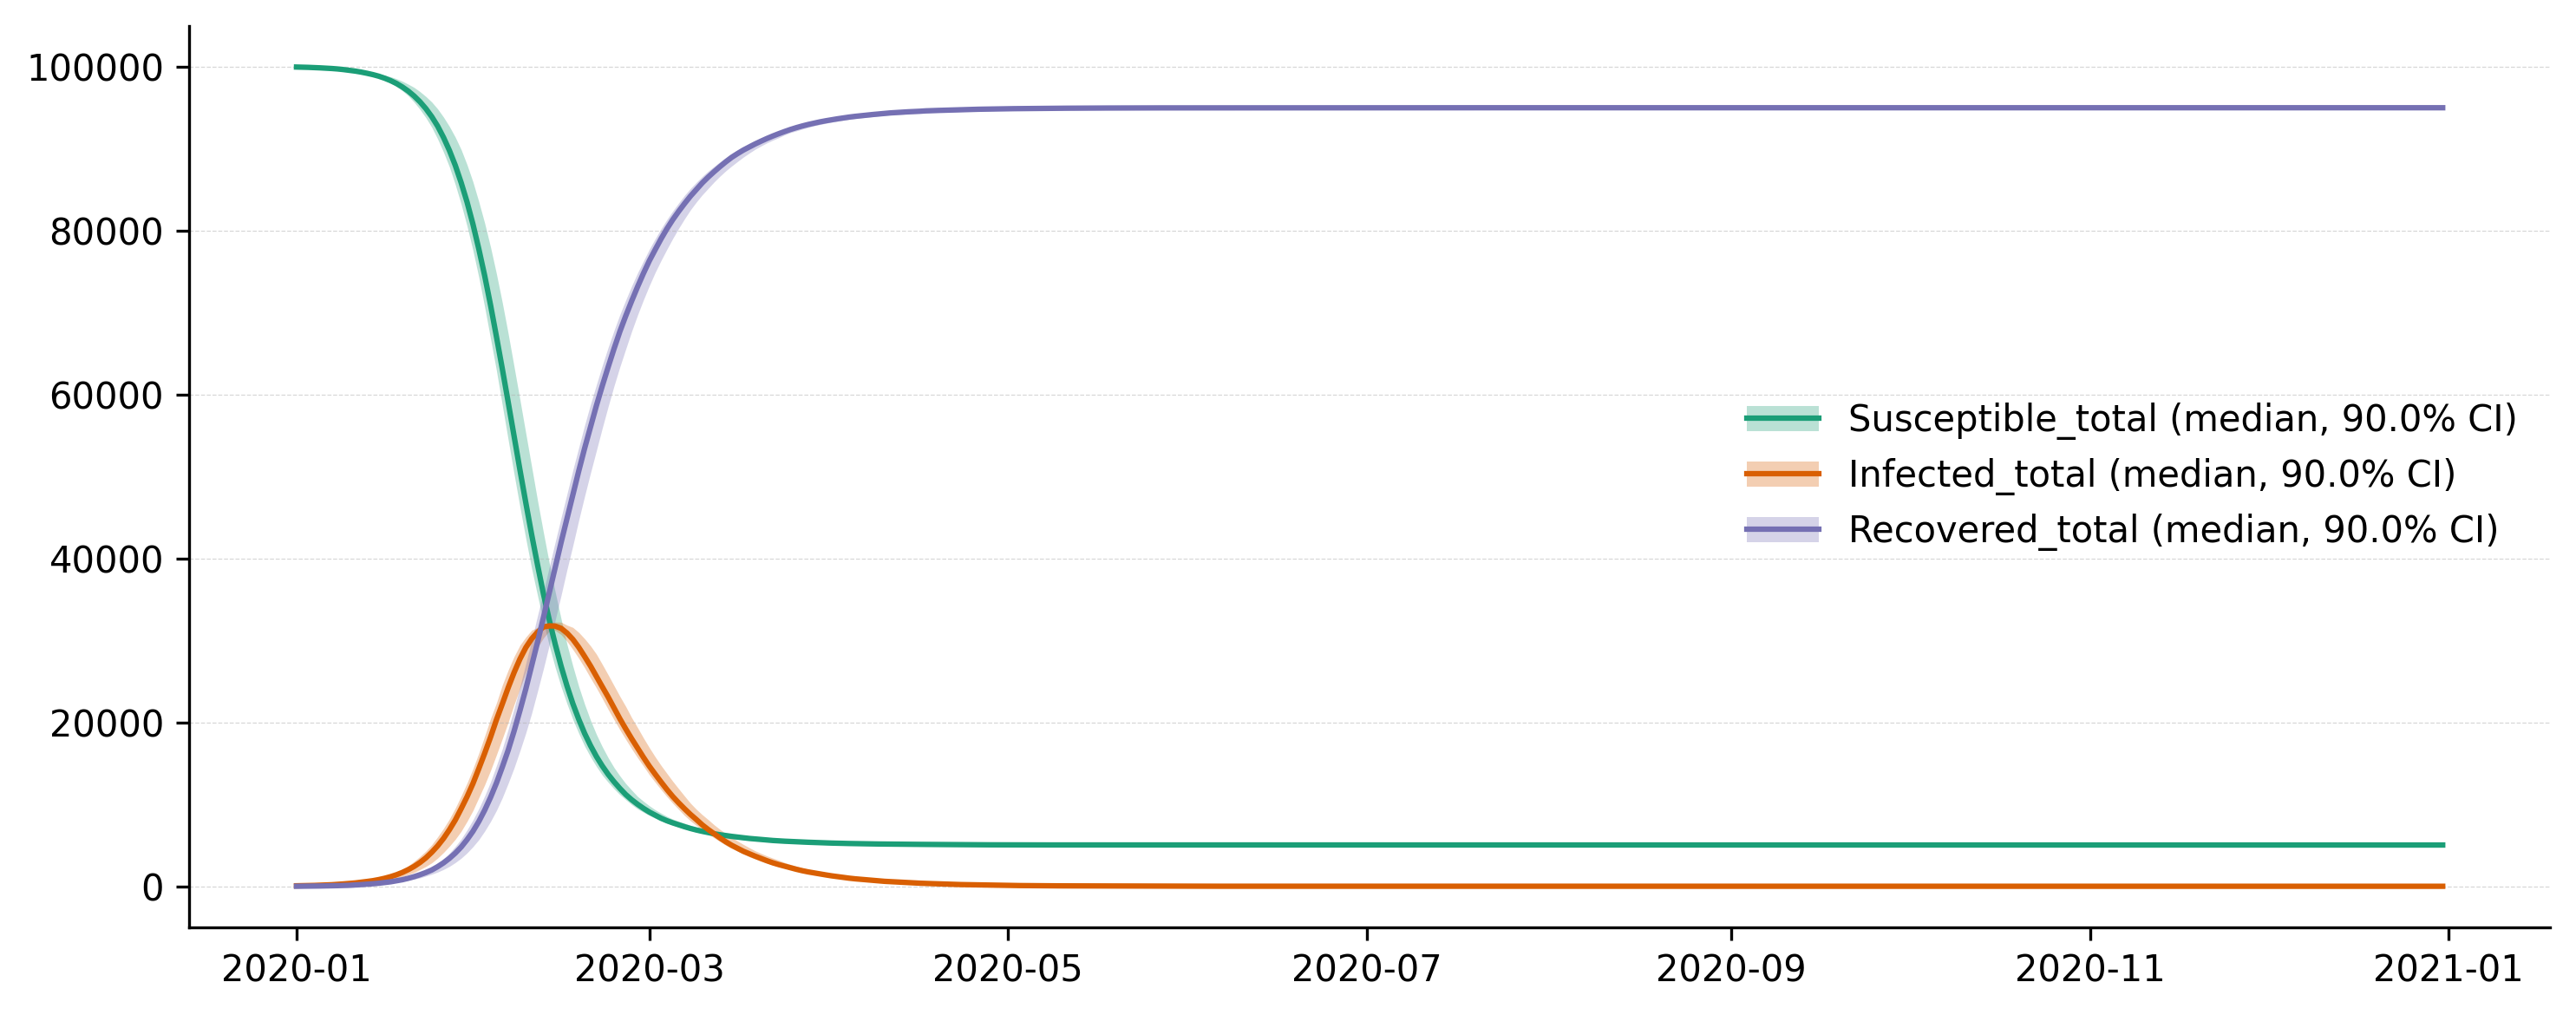

In [7]:
df_quantiles = merged_results.get_quantiles_compartments()
plot_quantiles(df_quantiles, columns=["Susceptible_total", "Infected_total", "Recovered_total"], legend_loc="center right")